<a href="https://colab.research.google.com/github/saugabriele/Machine_Learning_Project/blob/main/Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Malicious Url Detector Project**
To develop a classifier for detecting malicious URLs, the project started with a dataset containing a few URLs. In this case I tried to create a multiclass classifier that can classify a URL like:
- **Benign**: These are safe to browse URLs.
- **Phishing**: By creating phishing URLs, hackers try to steal sensitive personal or financial information such as login credentials
- **Malware**:These type of URLs inject malware into the victim’s system once he/she visit such URLs.
- **Defacement**: Defacement URLs are generally created by hackers with the intention of breaking into a web server and replacing the hosted website with one of their own

In [ ]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [ ]:
#Create a DataFrame from the dataset csv file
df = pd.read_csv("https://raw.githubusercontent.com/saugabriele/Machine_Learning_Project/main/malicious_phish1.csv")
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
#Convert the DataFrame in numpy arrays
url_array = df['url'].to_numpy()
type_array = df['type'].to_numpy()

##**Features Extraction**
To determine the class label of an URL, the first step was selecting the features that can be extracted from an URL. In this case i decided to extract some lexical features:
- These refer to statistical features extracted from the literal URL string. For example, length of the URL string, number of digits, number of parameters in its query part, if the URL is encoded, etc.

In [ ]:
def www_count(url):
  """
    From the input URL this will return the number of
    occurrences of the substring 'www'.
  """
  return url.count('www')

def at_count(url):
  """
    From the input URL this will return the number of
    occurrences of the substring '@'.
  """
  return url.count('@')

def url_lenght(url):
  """
    From the input URL this will return the
    corresponding length
  """
  return len(url)

def url_path_len(url):
  """
    From the input URL this will return the length
    of the path where the resource is located.
  """
  url_parse = urlparse(url)
  return len(url_parse.path)

def host_len(url):
  """
     From the input URL this will return the length
     of the hostname.
  """
  url_parse = urlparse(url)
  return len(url_parse.netloc)

def url_host_is_ip(url):
  """
    From the input URL this will return 1 if the hostname
    contains the IP adress otherwise it returns 0 if it
    contains the domain name where the resource is located.
  """
  url = urlparse(url)
  reg = r"^(([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.){3}([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])$"
  if re.match(reg, url.netloc):
      return 1
  else:
      return 0

def number_of_digits(url):
  """
    From the input URL this will return the number of
    digits in the URL.
  """
  digits = [i for i in url if i.isdigit()]
  return len(digits)

def number_of_parameters(url):
  """
    From the input URL this will return the number of
    parameters contained in the URL.
  """
  params = urlparse(url).query
  return 0 if params == '' else len(params.split('&'))

def number_of_subdirectories(url):
  """
    From the input URL this will return the number of
    subdirectories in the path of the URL.
  """
  d = urlparse(url).path.split('/')
  return len(d) - 1

def number_of_periods(url):
  """
    From the input URL this will return the number of
    periods in the URL.
  """
  return url.count('.')

def num_encoded_char(url):
  """
    From the input URL this will return the number of
    encoded characters in the URL.
  """
  return url.count('%')

def equal_count(url):
  """
    From the input URL this will return the number of
    variable values passed from one form page to another.
  """
  return url.count('=')

def count_http(url):
  """
    From the input URL this will return the number of
    occurrences of the substring 'http'.
  """
  return url.count('http')

def count_https(url):
  """
    From the input URL this will return the number of
    occurrences of the substring 'https'.
  """
  return url.count('https')

features_extraction_func = []
features_extraction_func.append(np.vectorize(www_count))
features_extraction_func.append(np.vectorize(at_count))
features_extraction_func.append(np.vectorize(url_lenght))
features_extraction_func.append(np.vectorize(url_path_len))
features_extraction_func.append(np.vectorize(host_len))
features_extraction_func.append(np.vectorize(url_host_is_ip))
features_extraction_func.append(np.vectorize(number_of_digits))
features_extraction_func.append(np.vectorize(number_of_parameters))
features_extraction_func.append(np.vectorize(number_of_subdirectories))
features_extraction_func.append(np.vectorize(number_of_periods))
features_extraction_func.append(np.vectorize(num_encoded_char))
features_extraction_func.append(np.vectorize(equal_count))
features_extraction_func.append(np.vectorize(count_http))
features_extraction_func.append(np.vectorize(count_https))

In [ ]:
def make_predictor_variables(features_extraction_func, urls):
  """
    From the URLs contained in the dataset this returns all
    the extracted features as a numpy array of
    shape = (number of URLs, number of features).
  """
  n_samples = url_array.shape[0]
  n_features = len(features_extraction_func)
  x = np.zeros(shape = (n_samples, n_features))

  for i, function in enumerate(features_extraction_func):
    x[:, i] = function(urls)

  return x

x = make_predictor_variables(features_extraction_func, url_array)

##**Features discriminant capability evaluation**
Now I made an analysis on the features discriminant capacibility, where i check the distribution of the features for all the classes. We the following four example we can see that:
- On average, the number of @ in the url is very high for phishing URLs and low for the others expecially for defacement URLs.
- On average, the url length is almost the same for all classes, a bit higher for defacement URLs.
- On average, the URL length is higher for benign URLs and lower for other classes.
- On average, the hostname path is very high for defacement  URLs and a bit smaller for malware URLs and lower for other classes expecially for benign URLs

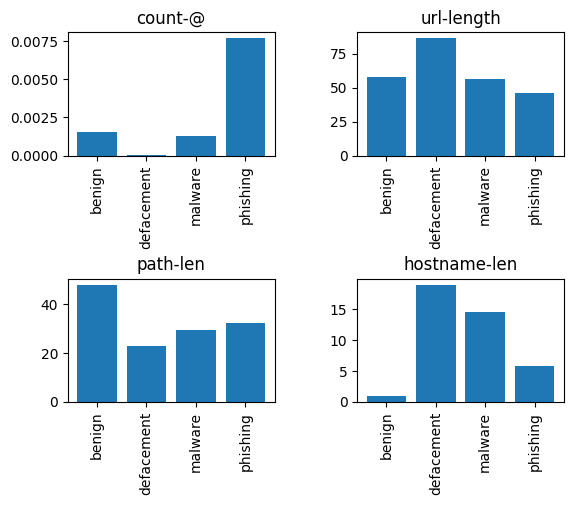

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=0.4)

plot_titles = ["count-@", "url-length", "path-len", "hostname-len"]
x_labels = np.unique(type_array)
height_plot = np.zeros(shape = (len(plot_titles), len(x_labels)))
x_plot = np.arange(1,5)

for j in range(len(plot_titles)):
  for i, label in enumerate(x_labels):
    height_plot[j][i] = x[type_array == label, j+1].mean()

for i in range(len(plot_titles)):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(plot_titles[i])
    ax.set_xticks(x_plot)
    ax.set_xticklabels(x_labels, rotation = 90)
    ax.bar(x_plot, height_plot[i])

##**Preprocessing and Train&Test Split**

In [ ]:
# Encoding of the target labels with value between 0 and n_classes-1
label_encoder =LabelEncoder()
Y = label_encoder.fit_transform(type_array)

# Define the scaler
scaler = MinMaxScaler()

# Train and test split
splitter = ShuffleSplit(n_splits=5, random_state=0, test_size=0.5)

In [ ]:
def run(x, y, splitter, scaler, clf):
    """
    Take input data (x,y), split it (n times), scale it,
    learn classifier on training data, and evaluate the mean test error.
    """
    acc = np.zeros(shape=(splitter.get_n_splits(),))
    pred_prob = None

    for i, (tr_idx, ts_idx) in enumerate(splitter.split(x, y)):
        xtr = x[tr_idx, :]
        ytr = y[tr_idx]
        xts = x[ts_idx, :]
        yts = y[ts_idx]

        xtr = scaler.fit_transform(xtr)
        xts = scaler.transform(xts)

        clf.fit(xtr, ytr)
        if (hasattr(clf.estimator, 'predict_proba')):
            pred_prob = clf.predict_proba(xts)
        ypred = clf.predict(xts)
        acc[i] = (ypred == yts).mean()
    return acc, pred_prob, yts

##**Results Presentation Functions**

In [ ]:
def print_result(clf, acc):
  """
    It takes in input the results of the evaluation of the different parameters
    passed in the grid using cross validation and the accuracy obtained using
    the best parameters for the estimator with test set and prints the results.
  """
  print("Parameters Estimation:")
  print("-Best parameters set found on training set:", clf.best_params_)
  print("-Grid scores on training set:")
  means = clf.cv_results_['mean_test_score']
  stds = clf.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, clf.cv_results_['params']):
      print("      %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

  print("\nMean test accuracy: {:.1%} +/- {:.1%}".format(acc.mean(), 2*acc.std()))
  print("Mean test error: {:.1%} +/- {:.1%}".format(1-acc.mean(), 2*acc.std()))
  return

In [ ]:
def roc_curve_computation(predict_proba, y_test, url_types = type_array):
  """
    It takes in input the test set and the class probabilities for the
    test set data points, then computes the roc curve and finally plots it.
  """
  classes=np.unique(url_types)
  n_class = classes.shape[0]

  #binarize the labels in a one-vs-all fashion
  y_test_binarized=label_binarize(y_test, classes=np.unique(y_test))

  # roc curve for classes
  fpr = np.empty(shape = [n_class], dtype = object)
  tpr = np.empty(shape = [n_class], dtype = object)
  thresh = np.empty(shape = [n_class], dtype = object)
  roc_auc = np.empty(shape = [n_class], dtype = object)


  for i in range(n_class):
      fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i],
                                            predict_proba[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])

      # plotting the four roc curves
      plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

  plt.plot([0,1],[0,1],'b--')
  plt.xlim([0,1])
  plt.ylim([0,1.05])
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='lower right')
  plt.show()

##**Models Building**

###**Nearest Centroid Classifier**

In [ ]:
from sklearn.neighbors import NearestCentroid

param_grid = {'metric': ('euclidean', 'manhattan')}

clf = GridSearchCV(estimator= NearestCentroid(), param_grid= param_grid)

acc, _, _  = run(x, Y, splitter, scaler, clf)

print_result(clf, acc)

Parameters Estimation:
-Best parameters set found on training set: {'metric': 'euclidean'}
-Grid scores on training set:
      0.812 (+/-0.002) for {'metric': 'euclidean'}
      0.562 (+/-0.001) for {'metric': 'manhattan'}

Mean test accuracy: 79.4% +/- 5.1%
Mean test error: 20.6% +/- 5.1%


###**Random Forest Classifier**

Parameters Estimation:
-Best parameters set found on training set: {'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'n_estimators': 15}
-Grid scores on training set:
      0.912 (+/-0.004) for {'max_depth': 7, 'max_features': 'sqrt', 'max_samples': 10000, 'n_estimators': 5}
      0.918 (+/-0.003) for {'max_depth': 7, 'max_features': 'sqrt', 'max_samples': 10000, 'n_estimators': 15}
      0.917 (+/-0.002) for {'max_depth': 7, 'max_features': 'sqrt', 'max_samples': None, 'n_estimators': 5}
      0.919 (+/-0.005) for {'max_depth': 7, 'max_features': 'sqrt', 'max_samples': None, 'n_estimators': 15}
      0.911 (+/-0.005) for {'max_depth': 7, 'max_features': 'log2', 'max_samples': 10000, 'n_estimators': 5}
      0.918 (+/-0.003) for {'max_depth': 7, 'max_features': 'log2', 'max_samples': 10000, 'n_estimators': 15}
      0.910 (+/-0.004) for {'max_depth': 7, 'max_features': 'log2', 'max_samples': None, 'n_estimators': 5}
      0.918 (+/-0.004) for {'max_depth': 7, 'max_featur

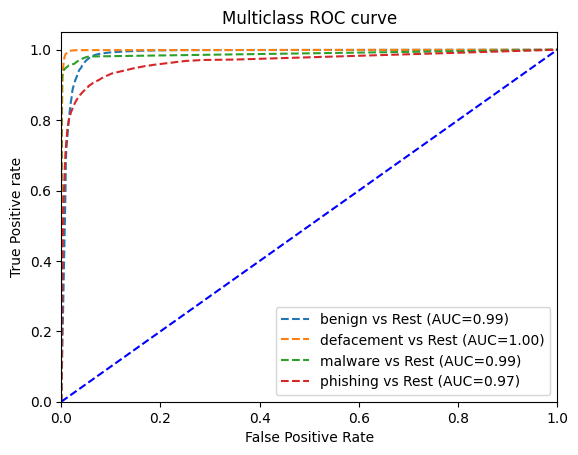

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': [5, 15], 'max_depth': [7, None],
          'max_features': ('sqrt', 'log2'), "max_samples": [10000, None]}

clf = GridSearchCV(estimator= RandomForestClassifier(), param_grid= params)

acc, pred_prob, yts = run(x, Y, splitter, scaler, clf)

print_result(clf, acc)
roc_curve_computation(pred_prob, yts)

###**Stochastic Gradient Descent - Linear SVM**

In [ ]:
from sklearn.linear_model import SGDClassifier

param_grid = {'alpha': [0.0005, 0.0001, 0.00005], 'tol': [0.005, 0.001, 0.0005]}

clf = GridSearchCV(estimator= SGDClassifier(), param_grid= param_grid)

acc, _, _ = run(x, Y, splitter, scaler, clf)

print_result(clf, acc)

Parameters Estimation:
-Best parameters set found on training set: {'alpha': 5e-05, 'tol': 0.005}
-Grid scores on training set:
      0.788 (+/-0.001) for {'alpha': 0.0005, 'tol': 0.005}
      0.786 (+/-0.003) for {'alpha': 0.0005, 'tol': 0.001}
      0.786 (+/-0.002) for {'alpha': 0.0005, 'tol': 0.0005}
      0.823 (+/-0.006) for {'alpha': 0.0001, 'tol': 0.005}
      0.825 (+/-0.003) for {'alpha': 0.0001, 'tol': 0.001}
      0.825 (+/-0.005) for {'alpha': 0.0001, 'tol': 0.0005}
      0.836 (+/-0.007) for {'alpha': 5e-05, 'tol': 0.005}
      0.835 (+/-0.007) for {'alpha': 5e-05, 'tol': 0.001}
      0.835 (+/-0.008) for {'alpha': 5e-05, 'tol': 0.0005}

Mean test accuracy: 83.6% +/- 0.4%
Mean test error: 16.4% +/- 0.4%


###**Stochastic Gradient Descent - Logistic Regression**

Parameters Estimation:
-Best parameters set found on training set: {'alpha': 5e-05, 'tol': 0.005}
-Grid scores on training set:
      0.769 (+/-0.002) for {'alpha': 0.0005, 'tol': 0.005}
      0.769 (+/-0.002) for {'alpha': 0.0005, 'tol': 0.001}
      0.769 (+/-0.002) for {'alpha': 0.0005, 'tol': 0.0005}
      0.817 (+/-0.002) for {'alpha': 0.0001, 'tol': 0.005}
      0.818 (+/-0.002) for {'alpha': 0.0001, 'tol': 0.001}
      0.817 (+/-0.004) for {'alpha': 0.0001, 'tol': 0.0005}
      0.829 (+/-0.004) for {'alpha': 5e-05, 'tol': 0.005}
      0.825 (+/-0.003) for {'alpha': 5e-05, 'tol': 0.001}
      0.826 (+/-0.004) for {'alpha': 5e-05, 'tol': 0.0005}

Mean test accuracy: 82.9% +/- 0.7%
Mean test error: 17.1% +/- 0.7%


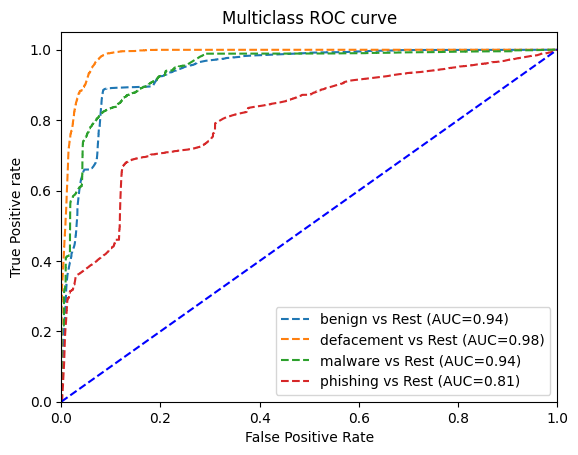

In [ ]:
from sklearn.linear_model import SGDClassifier

param_grid = {'alpha': [0.0005, 0.0001, 0.00005], 'tol': [0.005, 0.001, 0.0005]}

clf = GridSearchCV(estimator= SGDClassifier(loss= 'log_loss'), param_grid= param_grid)

acc, pred_prob, yts = run(x, Y, splitter, scaler, clf)

print_result(clf, acc)
roc_curve_computation(pred_prob, yts)